# Combify Coding Assignment - Ganesh Arumuganainar
# Task 1 - Data Processing

## Given Task: 

When you do the preprocessing of the data, we are more interested in familiarity with tools and although working at Combify doesn't always mean bigger is better, we prefer if you choose a distributed framework like PySpark or Apache Beam for the processing, but if that is out of your comfort zone, feel free to go along with Pandas. We are also interested in your reasoning of why you choose the features you do, so a basic data analysis is something we expect.

## 1. Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

## 2. Importing data from the csv file

In [2]:
data = pd.read_csv('raw_analyst_ratings.csv')

## 3. Visualise the data for insights

In [3]:
data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


Out of these data, 'url' and 'publisher' columns are not of interest to us. We keep only the 'headline', 'date' and 'stock' columns.  

In [4]:
data = data[['date','headline','stock']]
data.head()

,date,headline,stock
0,2020-06-05 10:30:54-04:00,Stocks That Hit 52-Week Highs On Friday,A
1,2020-06-03 10:45:20-04:00,Stocks That Hit 52-Week Highs On Wednesday,A
2,2020-05-26 04:30:07-04:00,71 Biggest Movers From Friday,A
3,2020-05-22 12:45:06-04:00,46 Stocks Moving In Friday's Mid-Day Session,A
4,2020-05-22 11:38:59-04:00,B of A Securities Maintains Neutral on Agilent...,A


## 4. Pre-processing

### Extract only date
Extracting only date from 'date' columnn would be interesting as it would help us visualise data on a single day.

In [5]:
date = []

for i in data['date']:
    date.append(i[:10])
    
data['date'] = date

In [6]:
data.head()

,date,headline,stock
0,2020-06-05,Stocks That Hit 52-Week Highs On Friday,A
1,2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,A
2,2020-05-26,71 Biggest Movers From Friday,A
3,2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,A
4,2020-05-22,B of A Securities Maintains Neutral on Agilent...,A


### Cleaning the 'headline' column

1. Lowercase all letters
2. Remove special characters
3. Remove all numbers
4. Decontract phrases

In [7]:
def decontracted(phrase):

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase
 


def clean(text):
   
    text = str(text)
    text = text.lower()
    text = decontracted(text)
    text = re.sub(r'\(([^)]+)\)', ' ', text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r' \w{1,2}_', ' ', text)
    text = re.sub('\s+',' ', text)
    
    return text

In [8]:
cleaned = []

for headline in data['headline']:
    cleaned.append(clean(headline))
    
data['headline_cleaned'] = cleaned

In [9]:
data = data[['date','headline_cleaned','stock']]
data.head()

,date,headline_cleaned,stock
0,2020-06-05,stocks that hit week highs on friday,A
1,2020-06-03,stocks that hit week highs on wednesday,A
2,2020-05-26,biggest movers from friday,A
3,2020-05-22,stocks moving in friday is mid day session,A
4,2020-05-22,b of a securities maintains neutral on agilent...,A


## 5. Feature Engineering - Sentiment Analysis

We have pre-processed the data and have simplified the big data by grouping headlines and stocks together under similar dates. Now, we have only 3955 rows and 3 columns. 

We apply sentiment analysis on the cleaned headlines to get insights on the trade call whether to sell/buy/hold stocks. There are multiple ways to carry out this analysis. 

1. To tokenise, remove stopwords and get n-grams 
2. Use the pre-trained sentiment analyzer VADER

We proceed with VADER. 

### Update VADER with new words

It is better to update VADER with new words and corresponding weights specifically for stock market analysis.

In [10]:
new_words = {'falls': -9, 'drops': -9, 'rise': 9, 
             'increases': 9, 'gain': 9, 'hiked': -9, 
             'dips': -9, 'declines': -9,
             'decline': -9, 'hikes': -9, 'jumps': 9, 
             'lose': -9, 'profit': 9, 'loss': -9, 
             'shreds': -9, 'sell': -9, 'buy': 9, 'recession': -9,
             'weakens': -9, 'low': -9, 'high': 9, 
             'up': 9, 'down': -9, 'lower':-9}

analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(new_words)

### Calculate compound score and trade call

VADER gives a compound score on each cleaned headline. More positivity (compound score > 0.2) in the news is considered as a 'BUY', more negativity (compound score < -0.2) in the news is considered as a 'SELL' and the neutral ones (compound score between -0.2 and 0.2) are considered as a 'HOLD' call.

In [11]:
compound_score = []

for headline in data['headline_cleaned']:
    score = analyser.polarity_scores(headline)['compound']
    
    if score < -0.2:
        compound_score.append(-1)
    
    elif score > 0.2:
        compound_score.append(1)
    
    else:
        compound_score.append(0)
        
data['sentiment'] = compound_score

In [12]:
data.head()

,date,headline_cleaned,stock,sentiment
0,2020-06-05,stocks that hit week highs on friday,A,0
1,2020-06-03,stocks that hit week highs on wednesday,A,0
2,2020-05-26,biggest movers from friday,A,0
3,2020-05-22,stocks moving in friday is mid day session,A,0
4,2020-05-22,b of a securities maintains neutral on agilent...,A,1


Now we have everything setup to do an exploratory data analysis

## 6. Exploratory data analysis

### Check for missing values

In [13]:
data.isna().sum()

date                0
headline_cleaned    0
stock               0
sentiment           0
dtype: int64

### Plot sentiment distribution

Text(0.5, 1.0, 'Sentiment - Countplot')

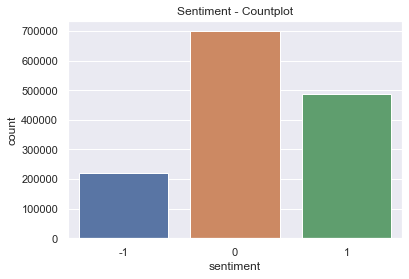

In [14]:
sns.set_theme(style='darkgrid')
ax = sns.countplot(x='sentiment', data=data)
ax.set_title('Sentiment - Countplot')

**Insights:** There are more neutral news than positive and negative news.

### Usage of words based on sentiment

It would be interesting to see the word usage for different sentiment types. We use a wordcloud plot to visualise this. For this, I used the same dataset after groupinng data all headlines unnder similar dates.

In [17]:
data_combined = pd.read_csv('analyst_ratings_processed.csv')

In [18]:
data_combined.head()

,date,headline_cleaned,stock,sentiment
0,2009-02-14,how treasuries and etfs work,['NAV'],1
1,2009-04-27,update on the luxury sector nd quarter update...,['FT' 'Y'],0
2,2009-04-29,going against the herd,['A'],0
3,2009-05-22,charles sizemore radio interview saturday morning,['AM'],0
4,2009-05-27,mrm a stock fit new information jva super trad...,['EPS' 'GMCR' 'JVA' 'RF'],1



Word Cloud for Positive Tweets


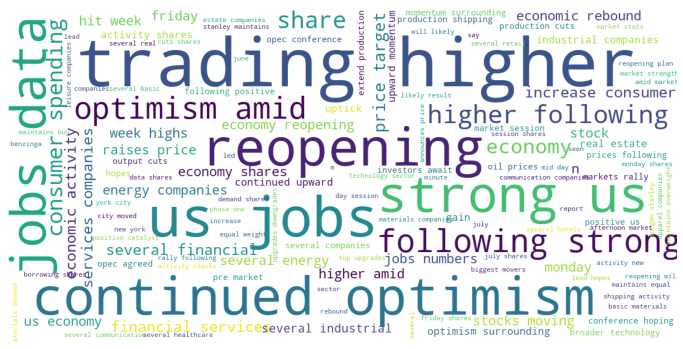


Word Cloud for Negative Tweets


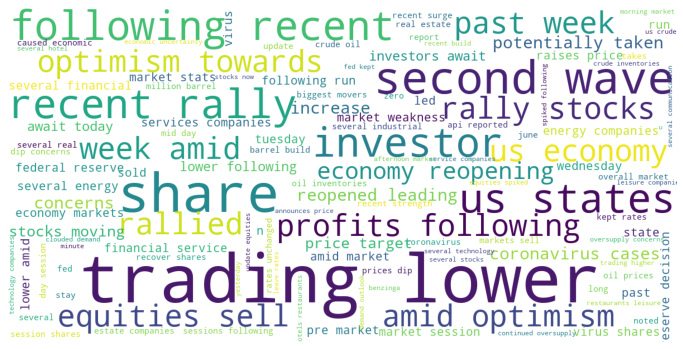


Word Cloud for Neutral Tweets


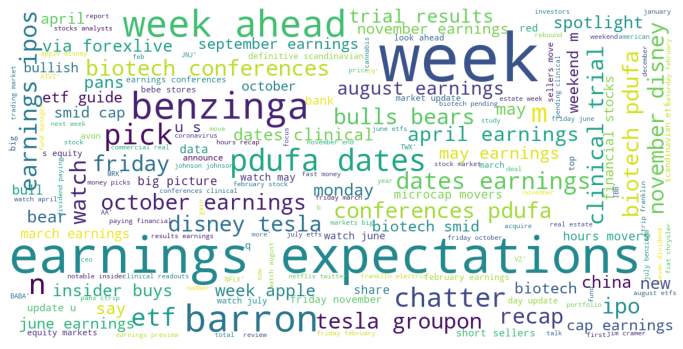

In [19]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200000,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

print('\nWord Cloud for Positive Tweets')
show_wordcloud(data_combined[data_combined['sentiment'] == 1].values)
print('\nWord Cloud for Negative Tweets')
show_wordcloud(data_combined[data_combined['sentiment'] == -1].values)
print("\nWord Cloud for Neutral Tweets")
show_wordcloud(data_combined[data_combined['sentiment'] == 0].values)

### Year wise distribution of sentiments

Text(0, 0.5, 'Sentiment Scores')

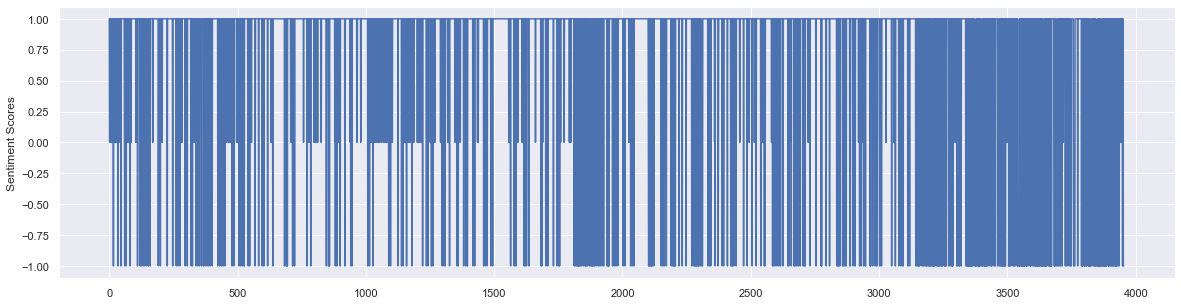

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(data_combined['sentiment'])
plt.ylabel('Sentiment Scores')

**Insights:** The number of news headlines have tremendously increased over years. In the last few years, the amount of data points we have are enormously large.  

## 7. Saving the data for task 2

In [16]:
data.to_csv(r'full_processed.csv', index=False)